## Read and plot MERRA-2 extreme detection indice monthly data subsetted by TDS 

**Objectives**
- Plot the time series averaged over U.S. and Canada, and the spatial maps of the selected years with heat wave events in North America in history.  
    
**Data and data tools**
- Data: Monthly Percentiles based on 1991-2020 V2 [M2SMNXPCT.2](https://doi.org/10.5067/FM4HEB84DL8C) 
- Subset: Use the Thematic Real-time Environmental Distributed Data Services (THREDDS) Data Server (TDS) to subset the data [Link of subset interface](https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/ncss/grid/MERRA2_CLIM_aggregation/M2SMNXPCT.2_Aggregation.ncml/dataset.html), [Tutorial of TDS](https://disc.gsfc.nasa.gov/information/howto?keywords=TDS&title=How%20to%20Obtain%20a%20Spatially%20Subsetted%20Time%20Series%20using%20TDS%20)
- Shapefile: Download the world country shapefile from [IPUMS International](https://international.ipums.org/international/resources/gis/IPUMSI_world_release2020.zip) to your local disk. 
- Mask: Download the world country mask file [here](https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2_CLIM/M2_TMAX_PM25.1/1980/) to your local disk.  
- Visualize: Use this Python script.  


**Author and Contact**
- Xiaohua Pan at NASA/GSFC/GES DISC (xiaohua.pan@nasa.gov)
- Last update: Feb. 27, 2024
    
**Disclaimer** 
- The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

**Notebook Citation**

<cite>Pan, X. (2024, February 9). Rising Heat Waves in North America in the Past 40 Years. Zenodo. https://doi.org/10.5281/zenodo.10642008</cite>


### Import modules

In [1]:
# you may need to install or update some libraries using pip or conda: 
# https://docs.anaconda.com/anaconda/user-guide/tasks/install-packages/ 
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
import xarray as xr
import warnings

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.mpl.geoaxes
import cartopy.crs as ccrs
import geopandas

import plotly.express as px
warnings.filterwarnings("ignore")

In [2]:
# -------------------------------------
# Make your choices on how to plot data
# -------------------------------------
# Product - NLDAS primary forcing data
product='M2SMNXPCT.2'

# Pre-select the quarter 
sel_quarter = 2    # 4 --> DJF, winter months 
if sel_quarter == 4:
    sel_quarter_str ='DJF'
elif sel_quarter == 1:
    sel_quarter_str ='MAM'
elif sel_quarter == 2:
    sel_quarter_str ='JJA'    
elif sel_quarter == 3:
    sel_quarter_str ='SON' 
    
# The number of years for rolling mean to see the trend and decadal variation 
nyr_rolling_mean = 5 
nmonth_rolling_mean = nyr_rolling_mean*12

In [3]:
%%time
# The subsetted and downloaded file using TDS (https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/ncss/grid/MERRA2_CLIM_aggregation/M2SMNXPCT.2_Aggregation.ncml/dataset.html)
file_dir='./data'
file_name = file_dir+'/MERRA2_CLIM_aggregation_'+product+'_Aggregation.nc'
# e.g., MERRA2_CLIM_aggregation_M2SMNXPCT.2_Aggregation.nc

# Read the data 
ds = xr.open_dataset(file_name)
ds

CPU times: user 11.2 ms, sys: 7.2 ms, total: 18.4 ms
Wall time: 17.9 ms


<xarray.Dataset>
Dimensions:  (time: 526, lat: 111, lon: 209)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T00:30:00 ... 2023-10-01T00:30:00
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 78.0 78.5 79.0 79.5 80.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -51.25 -50.62 -50.0
Data variables:
    PRECTOT  (time, lat, lon) float32 ...
    T2MMAX   (time, lat, lon) float32 ...
Attributes: (12/35)
    ShortName:                         M2SMNXPCT
    LongName:                          MERRA-2 statM_2d_pct_Nx: 2d, Single-Le...
    VersionID:                         v2_0
    Description:                       Percentile of Monthly MERRA-2 data bas...
    Format:                            NetCDF-4
    ProcessingLevel:                   Level 4
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    History:                           Translated to CF-1.0 Conventions by Ne...
    geospatial_lat_min:                25.0
    geospatial_lat_max:                80.0
    geospatial_lon_min:                -180.0
    geospatial_lon_max:                -50.0

In [4]:
# find the lat and lon ranges of the data 
lon_max = ds.lon.max().values; lon_min = ds.lon.min().values 
lat_max = ds.lat.max().values; lat_min = ds.lat.min().values 
type(max) 
print('lon:', lon_min, lon_max) 
print('lat:', lat_min, lat_max) 

lon: -180.0 -50.0
lat: 25.0 80.0


In [5]:
# ---------------------------------------------------
# Select your interested variable (e.g., T2MMAX)
# ---------------------------------------------------
sel_var_shortname = "T2MMAX"
#sel_var_shortname = "PRECTOT"
sel_var_value= ds[sel_var_shortname]
sel_var_longname = sel_var_value.attrs['long_name']
sel_var_unit = sel_var_value.attrs['units'] 
print("The selected variable is {}: {}{}".format(sel_var_shortname, sel_var_longname,sel_var_unit))

The selected variable is T2MMAX: Percentile for maximum 2-meter_air_temperaturePercent


In [6]:
# Plot selected season
# 'QS-DEC': Quarterly starting from Dec 1
#  references: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
#              https://stackoverflow.com/questions/52533630/how-to-select-an-inter-year-period-with-xarray
sel_var_value_quarter = sel_var_value.resample(time='QS-DEC').mean('time') 

print('sel_quarter_str=', sel_quarter_str)
sel_var_value_season=sel_var_value_quarter.sel(time=sel_var_value_quarter.time.dt.quarter.isin([sel_quarter])) 
sel_var_value_season

sel_quarter_str= JJA


<xarray.DataArray 'T2MMAX' (time: 44, lat: 111, lon: 209)>
array([[[37.134876 , 31.495356 , 29.487823 , ..., 53.01299  ,
         51.896908 , 52.738827 ],
        [38.697895 , 33.11537  , 35.155235 , ..., 50.674152 ,
         50.107666 , 49.41214  ],
        [38.63203  , 35.72836  , 36.192104 , ..., 52.206604 ,
         51.842937 , 50.927288 ],
        ...,
        [ 9.657672 ,  9.715978 , 10.284991 , ..., 47.23817  ,
         47.454884 , 49.569622 ],
        [10.961125 , 10.264248 ,  9.782924 , ..., 46.335438 ,
         46.09485  , 45.789997 ],
        [10.274902 ,  9.856253 ,  9.654855 , ..., 44.24771  ,
         44.400288 , 44.280273 ]],

       [[64.20306  , 67.20171  , 70.28667  , ..., 60.944958 ,
         58.143433 , 53.582657 ],
        [62.63506  , 63.915173 , 65.665726 , ..., 56.018612 ,
         58.208416 , 55.399555 ],
        [59.78966  , 58.54385  , 60.976196 , ..., 53.43973  ,
         53.75475  , 55.125195 ],
...
        [15.596911 , 15.579189 , 15.686751 , ..., 34.276093 ,
         34.6459   , 34.886936 ],
        [15.829373 , 14.361476 , 14.843776 , ..., 41.028545 ,
         40.170033 , 39.006702 ],
        [18.032518 , 17.762157 , 17.56656  , ..., 39.91238  ,
         39.484814 , 38.320698 ]],

       [[34.77625  , 38.20892  , 40.095974 , ..., 99.99     ,
         99.99     , 99.99     ],
        [33.35535  , 42.554413 , 43.33806  , ..., 99.99     ,
         99.99     , 99.99     ],
        [35.82575  , 42.54324  , 44.289745 , ..., 99.99     ,
         99.99     , 99.99     ],
        ...,
        [10.820615 , 10.998986 , 11.68356  , ..., 77.59656  ,
         77.70365  , 77.8472   ],
        [11.532733 , 11.456444 , 11.937127 , ..., 77.37339  ,
         77.443275 , 77.52918  ],
        [11.682132 , 11.647473 , 11.839284 , ..., 75.443634 ,
         76.006775 , 77.55802  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 78.0 78.5 79.0 79.5 80.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... -51.25 -50.62 -50.0
  * time     (time) datetime64[ns] 1980-06-01 1981-06-01 ... 2023-06-01
Attributes:
    long_name:    Percentile for maximum 2-meter_air_temperature
    units:        Percent
    valid_range:  [ 0.     99.9999]
    _ChunkSizes:  [  1 361 576]

In [7]:
%%time
# Read netCDF file with world country and territory masks in the current directory
# Note: read in US county mask here instead of the world country mask to average the varaible for US counties
mask_file = './ancillary/mask_worldCountry_MERRA2.nc'
masks = xr.open_dataset(mask_file)
masks

CPU times: user 37.6 ms, sys: 4.45 ms, total: 42 ms
Wall time: 41.1 ms


<xarray.Dataset>
Dimensions:                           (time: 1, lon: 576, lat: 361)
Coordinates:
  * time                              (time) datetime64[ns] 2016-01-01
  * lon                               (lon) float64 -180.0 -179.4 ... 179.4
  * lat                               (lat) float64 -90.0 -89.5 ... 89.5 90.0
Data variables: (12/232)
    regions                           (time, lat, lon) float32 ...
    Argentina                         (time, lat, lon) float32 ...
    Bolivia                           (time, lat, lon) float32 ...
    Brazil                            (time, lat, lon) float32 ...
    Chile                             (time, lat, lon) float32 ...
    Colombia                          (time, lat, lon) float32 ...
    ...                                ...
    Mauritius                         (time, lat, lon) float32 ...
    Madagascar                        (time, lat, lon) float32 ...
    Comoros                           (time, lat, lon) float32 ...
    Mayotte                           (time, lat, lon) float32 ...
    Seychelles                        (time, lat, lon) float32 ...
    cell_area                         (lat, lon) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.10 (https:/...
    Conventions:               CF-1.6
    nco_openmp_thread_number:  1
    NCO:                       4.4.4
    title:                     Country masks
    references:                Center for International Earth Science Informa...
    history:                   Fri Apr 21 16:25:11 2023: cdo merge GPW3_Glb_5...
    legend:                    Code;CountryEnglish;ISO3v10;ContinentName\n2;A...
    publisher_url:             https://eccad.aeris-data.fr
    CDO:                       Climate Data Operators version 1.9.10 (https:/...

# Read netCDF file with population density (this is used for aggegating the value for world countries) 
popdens_file = './ancillary/mask_worldPopulation_MERRA2.nc'
pop = xr.open_dataset(popdens_file)
popvar = 'Population Density, v4.10 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'  # variable name 
pop


In [8]:
# Define functions:
SKIPVARS = ['mask','regions','cell_area']
def _calc_country_value(itime,variable,masks,pop=None):
    '''Calculate average value for each mask and for the given time'''
    # select sel_var_value slice for the time of interest
    variable_itime = variable.sel(time=itime,method='nearest')
    # select closest population density
    if pop is not None:
        ipop = _get_var(pop,popvar,itime,variable_itime)
    else:
        ipop = None
    # initialize data table with averaged sel_var_value
    dat = pd.DataFrame()
    dat['date'] = [itime]
    # loop over all masks and calculate average variable per mask area. Write into table
    for m in masks:
        if m in SKIPVARS:
            continue
        #imask = _get_var(masks,m,itime,pm25) #original (buggy)
        imask = _get_var(masks,m,itime,variable_itime) #fix
        wgt = imask.values[:,:]*ipop.values[:,:] if ipop is not None else imask.values[:,:]
        ival = np.sum(variable_itime.values[:,:]*wgt[:,:]/np.sum(wgt)) if np.sum(wgt) > 0.0 else 0.0
        #print('m=', m) 
        dat[m] = [ival]
    return dat

def _get_var(ds,var,itime,variable_itime):
    '''wrapper function to get variable from a dataset and regrid onto the variable_itime grid if necessary'''
    da = ds[var].sel(time=itime,method='nearest')
    da.values[np.isnan(da.values)] = 0.0
    if da.shape != variable_itime.shape:
        #print('variable {} not on same grid - interpolate onto sel_var_value grid...'.format(var))
        da = da.interp_like(variable_itime) 
    return da

In [9]:
%%time    
# Calculate averages for each country
# Initialize
dats = []

# Loop over each year
for t in sel_var_value_season.time.values:    
    # Grab the current time
    itime = pd.Timestamp(t)
    print(itime.strftime('working on %Y-%m'))
    
    # Calculate averages for each country 
    # Note: users can choose if they want the value 
    #       weighted by population density by uncommenting line 12
    #       and commenting line 13
    #
    #idat = _calc_country_value(itime,sel_var_value_season,masks,pop) # with population density weighting (for world countries only)
    idat = _calc_country_value(itime,sel_var_value_season,masks,pop=None) # without weighting [default]
    
    # Append current time's processed value 
    dats.append(idat)

# Make final dataframe 
data = pd.concat(dats)


working on 1980-06
working on 1981-06
working on 1982-06
working on 1983-06
working on 1984-06
working on 1985-06
working on 1986-06
working on 1987-06
working on 1988-06
working on 1989-06
working on 1990-06
working on 1991-06
working on 1992-06
working on 1993-06
working on 1994-06
working on 1995-06
working on 1996-06
working on 1997-06
working on 1998-06
working on 1999-06
working on 2000-06
working on 2001-06
working on 2002-06
working on 2003-06
working on 2004-06
working on 2005-06
working on 2006-06
working on 2007-06
working on 2008-06
working on 2009-06
working on 2010-06
working on 2011-06
working on 2012-06
working on 2013-06
working on 2014-06
working on 2015-06
working on 2016-06
working on 2017-06
working on 2018-06
working on 2019-06
working on 2020-06
working on 2021-06
working on 2022-06
working on 2023-06
CPU times: user 35 s, sys: 1.2 s, total: 36.2 s
Wall time: 36.2 s


## Plot data:

In [10]:
data.tail(10)

,date,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Falkland_Islands,French_Guiana,Guyana,...,Zambia,Zimbabwe,Cape_Verde,Sao_Tomé_and_Principe,Saint_Helena,Mauritius,Madagascar,Comoros,Mayotte,Seychelles
0,2014-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2015-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2016-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2018-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2019-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2021-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2022-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2023-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data = data.set_index('date')
data.tail()

,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Falkland_Islands,French_Guiana,Guyana,Peru,...,Zambia,Zimbabwe,Cape_Verde,Sao_Tomé_and_Principe,Saint_Helena,Mauritius,Madagascar,Comoros,Mayotte,Seychelles
date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data.index.year[-1]

2023

In [13]:
# Plot the country maps inset in the line plot below
# read the shapefile from disk. Geopandas will return a GeoDataFrame object which is similar to a pandas DataFrame.
countries = geopandas.read_file('./ancillary/shapefiles/IPUMSI_world_release2020/world_countries_2020.shp')
Canada = countries[countries['CNTRY_NAME'].isin(['Canada'])]
United_States = countries[countries['CNTRY_NAME'].isin(['United States'])]

 Pick up your figure  ./fig/Line_TDS_M2SMNXPCT.2_T2MMAX_JJA_rollingmean.png


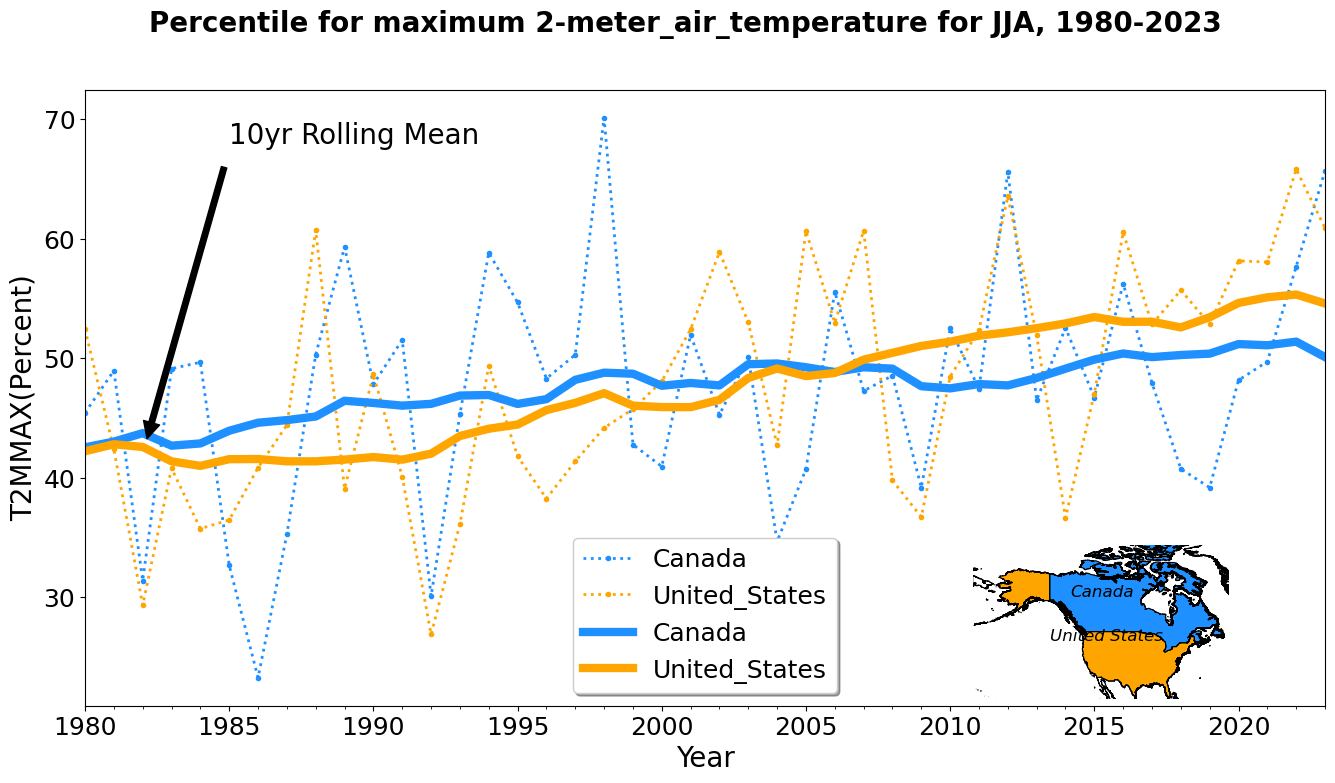

In [14]:
# Make line plot overlaid with trend (rolling mean) 
# Reference: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
# Only plot North America
sel_countries = ['Canada', 'United_States']
North_America = data[sel_countries]

# Trend: 20 year rolling mean 
North_America_10yr = North_America.rolling(window=20, center=True, min_periods=10).mean()

# Plot all lines in one panel 
fig, ax = plt.subplots(figsize=(16,8))

# plot seasonal mean 
line_colors = ['dodgerblue', 'orange']
sel_countries2 = [x + ' 10yr Rolling Mean' for x in sel_countries]

North_America.plot.line(ax=ax, marker='.', linestyle='dotted', linewidth=2, label = sel_countries, color=line_colors)

# plot trend
North_America_10yr.plot.line(ax=ax, marker='.', linestyle='-', linewidth=6, label=sel_countries2, color=line_colors)

# Annotation for the thick lines since their label doesn't show the full name, why? 
ax.annotate('10yr Rolling Mean', xy =('1982-06-01', 42),  #xy: where the pointer is 
                xytext =('1985-06-01', 68), fontsize= 20, #xytext: where the text is 
                arrowprops = dict(facecolor ='black', 
                                  shrink = 0.05),) 

# Plot main title and xy labels
main_title = "{} for {}, {}-{}".format(sel_var_longname,sel_quarter_str, data.index.year[0], data.index.year[-1])  
plt.suptitle(main_title, fontweight='bold', fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel(sel_var_shortname+'('+sel_var_unit+')', fontsize=20)
#ax.legend(loc='upper left', fontsize=20);
ax.legend(shadow=True, fancybox=True, fontsize=18, loc='lower center')
ax.tick_params(labelsize=18)

# Create map inset to highlight the area of interest (AOI)
#    Reference: https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html
#       e.g., width 25% and height 25% of the parent axes' bounding box at the upper left corner (loc=2)   
axins = inset_axes(ax, width="35%", height="25%", loc=4,
                   axes_kwargs=dict(
                    facecolor="none"))

xlim = ([lon_min, lon_max])
ylim = ([lat_min, lat_max])

axins.set_xlim(xlim)
axins.set_ylim(ylim)

# Plot the highlighted countries
countries_map = countries.boundary.plot(ax=axins, color="black", linewidth=.8)
Canada.plot(ax=countries_map,  color=line_colors[0])
Canada.apply(lambda x: countries_map.annotate(x.CNTRY_NAME, xy=x.geometry.centroid.coords[0], ha='right', color='black',
                                                      fontsize=12, fontstyle='italic'),axis=1);
United_States.plot(ax=countries_map,  color=line_colors[1])
United_States.apply(lambda x: countries_map.annotate(x.CNTRY_NAME, xy=x.geometry.centroid.coords[0], ha='center', color='black',
                                                      fontsize=12, fontstyle='italic'),axis=1);
countries_map.axis('off')
    
#United_States.plot(ax=world_boundary_map, color="dodgerblue")

# Save the plot 
figFile_plot = "./fig/Line_TDS_{}_{}_{}_rollingmean.png".format(product,sel_var_shortname, sel_quarter_str)
plt.savefig(figFile_plot, dpi=70)
print(" Pick up your figure ", figFile_plot)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
['1980-06', '1983-06', '1988-06', '2001-06', '2006-06', '2011-06', '2012-06', '2018-06', '2020-06', '2021-06', '2022-06', '2023-06']
index = 0
index = 1
index = 2
index = 3
index = 4
index = 5
index = 6
index = 7
index = 8
index = 9
index = 10
index = 11
 Pick up your figure  ./fig/Map_TDS_M2SMNXPCT.2_T2MMAX_JJA.png


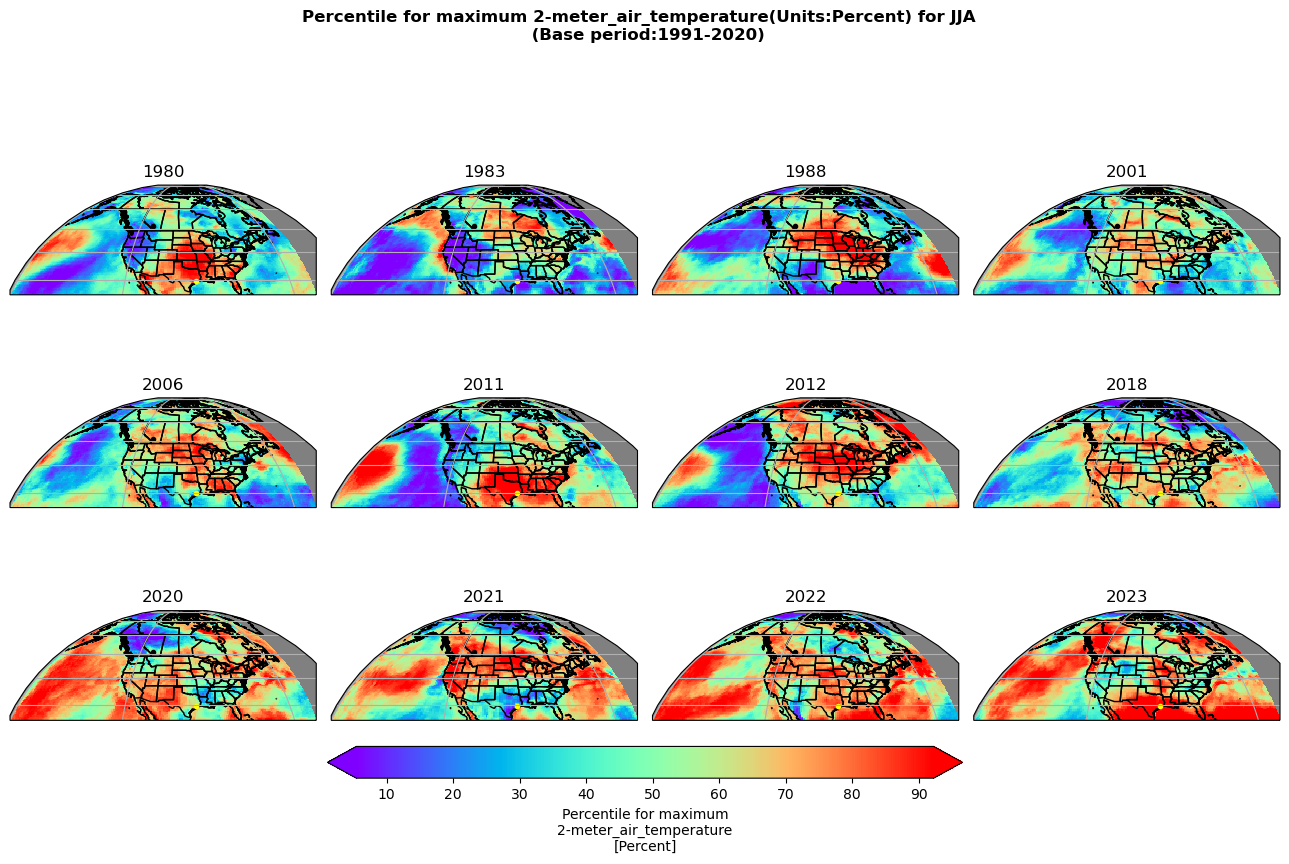

In [15]:
%time
# Plot the spatial map in the select years when North America experienced heat waves
# References: https://en.wikipedia.org/wiki/Category:Heat_waves_in_the_United_States
# sel_heatwave_years_in_NA = ['1980','2000', '2001', '2006', '2007', '2011', '2012', '2018', '2021', '2022', '2023']
sel_heatwave_years_in_NA = ['1980','1983', '1988','2001', '2006', '2011', '2012', '2018','2020', '2021', '2022', '2023']
sel_heatwave_yearmons_in_NA = [ year+'-06' for year in sel_heatwave_years_in_NA]
print(sel_heatwave_yearmons_in_NA)

#fig, ax = plt.subplots(figsize=(15, 8))
g_simple_map = sel_var_value_season.sel(time=sel_heatwave_yearmons_in_NA).plot.pcolormesh(x="lon", y="lat", col="time", col_wrap = 4, 
                                        robust=True,
                                        cmap="rainbow",
                                        transform=ccrs.PlateCarree(),
                                        #subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
                                        subplot_kws=dict(projection=ccrs.Orthographic(central_longitude=-100, central_latitude=0.), facecolor="gray"),
                                        cbar_kwargs=dict(orientation='horizontal',
                                        pad=0.03, shrink=0.5))

# Plot main title and xy labels
main_title = "{}(Units:{}) for {}  \n (Base period:1991-2020)".format(sel_var_longname,sel_var_unit, sel_quarter_str)  
#ax.set_title('Monthly Air Temperature Anomalies over Texas in '+sel_date.strftime("%b")+' (reference period:1980-2009)', 
    #             fontweight='bold')
plt.suptitle(main_title, fontweight='bold')
#    ax.text(-101, 34.5, '(ref. period:1980-2009)', 
#                transform=ccrs.Geodetic())


for index, ax in enumerate(g_simple_map.axs.flat):
    ax.coastlines(),
    ax.gridlines()
    ax.add_feature(cartopy.feature.STATES)
    
    # Narrow down the mapping extent 
    ax.set_extent([lon_min, lon_max, lat_min,lat_max], ccrs.Geodetic())

    # subtitle
    if index < len(sel_heatwave_years_in_NA): 
        print ('index =', index) 
        subtitle = "{}".format(sel_heatwave_years_in_NA[index] )
        ax.set_title(subtitle)
    
    # mark a known place to help us geo-locate ourselves
    # sel_site_names = ['Phoenix']
    # sel_site_lons = ['-112.0740']
    # sel_site_lats = ['33.4484' ]
    
    sel_site_names = ['Cagary', 'Houston'] 
    sel_site_lats = [51.0447, 29.77]
    sel_site_lons = [-114.0719, -95.37]
    sel_site_colors = ['black','yellow']

    nsite = len(sel_site_names)
    for isite in range(nsite): 
        ax.plot(sel_site_lons[isite],sel_site_lats[isite], 'bo', color=sel_site_colors[isite], markersize=3, 
                transform=ccrs.Geodetic())
        
#plt.draw()
# Make it nice
#plt.tight_layout()

# Save the plot 
figFile_plot = "./fig/Map_TDS_{}_{}_{}.png".format(product,sel_var_shortname, sel_quarter_str)
plt.savefig(figFile_plot, dpi=70)
print(" Pick up your figure ", figFile_plot) 